# Problem 1:

Note for no layers, we have 784 inputs going to 10 outputs, and we assume a bias term per each.  This will yield 
$10 \cdot 784 $ parameters, as we have each pixel weighted, and 10 outputs, with a further 10 bias terms, one for each 
output node.  Therefore there is a total of $7840 + 10 = 7850$ parameters when we don't include a hidden layer.

If a model has $k$ hidden layers with $m$ nodes a piece we have the following calculation: For the first layer we have $784m + m$ parameters for intaking from the image to the first layer.  For the next $k-1$ layers, for each layer we have $m^2$ 
interconnects, and $m$ bias terms yielding $(k-1)(m^2 + m)$ parameters.  Finally we have $10m$ connections into the output layer, with an additionally $10$ bias.  Therefore, $$Params(m,k) = 784m + m + (k-1)(m^2 + m) + 10(m+1)$$.

# Problem 2:

For a given number of parameters P, we have the equation $784m + m + (k-1)(m^2 + m) + 10(m+1) = P.$  We can rearrange the equation to find that $k = \frac{P-10}{m(m+1)} - \frac{795}{m+1} + 1$.  In order to maximize/minimize the function 
we can take the m derivative, and set the numerator of the fraction equal to zero.  In this scenerio 
we have to solve the equation $0=-795m^2 + 2(P-10)m + (P-10)$.  This has the resulting $m$ values of 
$$ m = \frac{1}{795} \left(P-10 \pm \sqrt{(P-10)^2+795(P-10)} \right) $$.  Note that for sufficently large $P$ that 
the square root will always be positive, thus we will always have two roots, a maximum and a minimum.  However, 
for the smaller of the two roots, the limit approaches -0.5, and since we know that by our model we have to have at least 1 parameter per layer implies that solving for $m=1$ will yield $k_p$.  For the smallest $k$, we know for the smaller root $m_b$ that $\lim_{P \to \infty} k(m_b) = -1$.  Thus 
the smallest possible $k$ would have to be $k=1$.  Note that if $k_p$ is not an integer then one should round $k_p$ down since $m$ is already the 
correct integer of 1 then the actual number of used parameters falls "under budget".  

# Problem 3:

In [56]:
def m_num(k,P):
    if k == 1:
        return (P-10) // 795
    else:
        return (int)(math.sqrt((794+k)**2 + 4*(P-10)*(k-1)))// (2*(k-1))

In [42]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


9.9%

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




100.0%
100.0%

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [17]:
test_x = torch.Tensor( testset.data ) / 256.0 - 0.5
test_x = test_x.to(device)
test_y = torch.Tensor( testset.targets ).long()
test_y = test_y.to(device)
train_x = torch.Tensor( trainset.data ) / 256.0 - 0.5
train_x = train_x.to(device)
train_y = torch.Tensor( trainset.targets ).long()
train_y = train_y.to(device)

In [7]:
def get_batch(x, y, batch_size):
    n = x.shape[0]

    batch_indices = random.sample( [ i for i in range(n) ], k = batch_size )

    x_batch = x[ batch_indices ]
    y_batch = y[ batch_indices ]

    return x_batch, y_batch

In [59]:
class layerTesting(nn.Module):
    def __init__(self,k,m):
        super(layerTesting, self).__init__()

        self.layer_input = torch.nn.Linear( in_features = 28*28*1, out_features = m, bias=True )
        self.layer_output = torch.nn.Linear( in_features = m, out_features = 10, bias=True )
        self.linears = nn.ModuleList([nn.Linear(m, m) for i in range(k-1)])
        self.normalize = nn.LayerNorm(m)

    def forward(self, input_tensor):
        output = nn.Flatten()( input_tensor )
        output = self.layer_input(output)
        output = nn.ReLU()(output)
        output = self.normalize(output)
        for l in self.linears:
            output = l(output)
            output = nn.ReLU()(output)
            output = self.normalize(output)
        output = self.layer_output(output)
        return output

In [19]:
def confusion_matrix( model, x, y ):
    identification_counts = np.zeros( shape = (10,10), dtype = np.int32 )
    
    logits = model.forward( x )
    predicted_classes = torch.argmax( logits, dim = 1 )

    n = x.shape[0]

    for i in range(n):
        actual_class = int( y[i].item() )
        predicted_class = predicted_classes[i].item()
        identification_counts[actual_class, predicted_class] += 1

    return identification_counts

In [63]:
model3 = layerTesting(3,m_num(3,100000))
model3.to(device)
loss_function = torch.nn.CrossEntropyLoss()

print("Initial Confusion Matrix")
print( confusion_matrix( model3, test_x, test_y ) )

Initial Confusion Matrix
[[233  22 132 323   6   4 142  61  13  44]
 [ 77  35  16  48   2   0 376 186   0 395]
 [127  31  29  95  19   8 449 131   7 136]
 [260  14  54  64   3   5 106  29   2 473]
 [357  19  36 113  22   3 156  62 102 112]
 [144  19  77 119   6   5 124  15   8 375]
 [197  22 122 181  23   8 305  34  39  27]
 [ 78   8  31 304  20   1  98  15  53 420]
 [167  33  47 104   7   2 139  25   4 446]
 [271   6  12 284  23   0 105   6  65 237]]


Based off of Dr.Cowan's suggestions, I'm using $P=100000$ and $k=1\ldots 10$

In [85]:
P = 100000
batch_size = 256
finalLoss = []
for k in range(1,10+1):
    model = layerTesting(k,m_num(k,P))
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 0.0005 )
    for epochs in range(30):
        total_loss = 0
        for batch in range( train_x.shape[0] // batch_size ):
            x_batch, y_batch = get_batch(train_x, train_y, batch_size)
            
            optimizer.zero_grad()
    
            logits = model( x_batch )
            loss = loss_function( logits, y_batch )
    
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
        print( k,"layer(s), total Loss over Batches:",total_loss )
    finalLoss.append(loss_function(model(test_x), test_y))
    print("Current Confusion Matrix")
    print( confusion_matrix( model, test_x, test_y ) )
    print()

1 layer(s), total Loss over Batches: 112.13224667310715
1 layer(s), total Loss over Batches: 47.265556663274765
1 layer(s), total Loss over Batches: 34.30731004476547
1 layer(s), total Loss over Batches: 28.28384868055582
1 layer(s), total Loss over Batches: 22.089966915547848
1 layer(s), total Loss over Batches: 19.833004884421825
1 layer(s), total Loss over Batches: 18.212733067572117
1 layer(s), total Loss over Batches: 15.826028142124414
1 layer(s), total Loss over Batches: 14.187432203441858
1 layer(s), total Loss over Batches: 13.56040854845196
1 layer(s), total Loss over Batches: 11.824485362507403
1 layer(s), total Loss over Batches: 10.471789793111384
1 layer(s), total Loss over Batches: 9.833379683084786
1 layer(s), total Loss over Batches: 9.011000362224877
1 layer(s), total Loss over Batches: 8.571620187722147
1 layer(s), total Loss over Batches: 8.24829336348921
1 layer(s), total Loss over Batches: 7.8487286157906055
1 layer(s), total Loss over Batches: 7.630080476403236
1

In [88]:
print(finalLoss[1].item())

0.08009275794029236


Text(0, 0.5, 'testing loss')

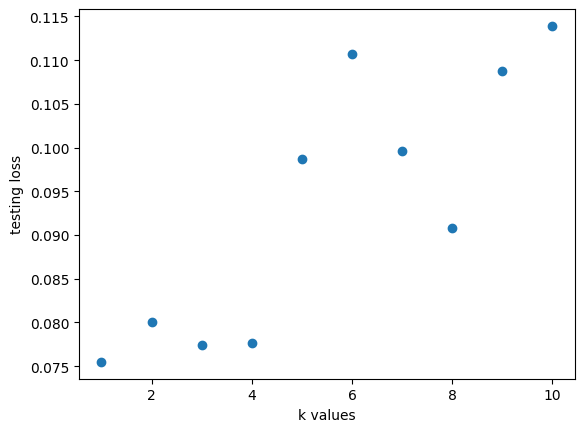

In [90]:
plt.plot([i for i in range(1,11)],[j.item() for j in finalLoss],'o')
plt.xlabel("k values")
plt.ylabel("testing loss")